In [1]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models

  Cloning https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models to /tmp/pip-req-build-w3re7ong
  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models /tmp/pip-req-build-w3re7ong
  Resolved https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models to commit 975885b1f6814fd5958199919b33e02a6a9aa152
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.7/234.7 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 93.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━

# Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Lambda, Reshape, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, initializers,regularizers
from tensorflow.keras.losses import binary_crossentropy
# from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from keras.losses import MeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib as mpl
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

from matplotlib import cm
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow.keras.losses import Loss
from tensorflow.keras.utils import to_categorical

# Dataset

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Conjunto de datos de entrenamiento, testeo y validación normalizados.

In [4]:
# Asegurarse de que las imágenes tengan la forma correcta (batch_size, 28, 28, 1)
X_train = np.expand_dims(X_train, -1)
X_valid = np.expand_dims(X_valid, -1)

# Convertir las etiquetas a one-hot encoding
num_classes = 10
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_valid_one_hot = tf.keras.utils.to_categorical(y_valid, num_classes=num_classes)

In [5]:
X_train.shape

(55000, 28, 28, 1)

In [6]:
y_train.shape

(55000,)

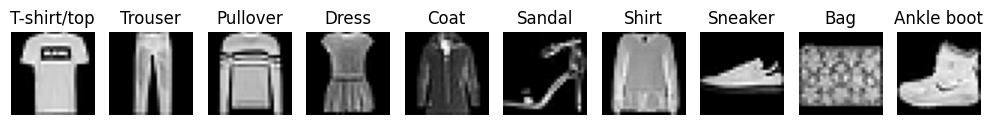

In [7]:
plt.figure(figsize=(10, 5))

# Etiquetas 
categories = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


for i in range(10):
    # Encontrar el primer ejemplo de la categoría actual
    example_index = np.where(y_train == i)[0][0]
    image = X_train[example_index]
    
    # Configurar un subgráfico para cada categoría
    plt.subplot(1, 10, i + 1)  
    plt.imshow(image, cmap='gray')
    plt.title(categories[i])
    plt.axis('off') 

plt.tight_layout()
plt.show()

Las etiquetas de la base de datos Mnist Fashion

# Functions

In [8]:
@tf.keras.utils.register_keras_serializable()
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
def plot_mnist_autoencoder(x, x_, y=None, y_=None, cmap='gray', vmin=0, vmax=1):
    """
    Plot the original and reconstructed MNIST images using an autoencoder, including labels.
    
    Parameters:
    ----------
    x : Sequence[np.ndarray]
        Original images.
    x_ : Sequence[np.ndarray]
        Reconstructed images.
    y : Optional[Sequence], optional
        True labels of the images, by default None.
    y_ : Optional[Sequence], optional
        Predicted labels of the images, by default None.
    cmap : str, optional
        Color map for the images, by default 'gray'.
    vmin : float, optional
        Minimum value for normalization, by default 0.
    vmax : float, optional
        Maximum value for normalization, by default 1.
    """
    plt.figure(figsize=(20, 4))
    num_images = len(x)
    
    for i in range(num_images):
        # Display original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(x[i].reshape(28, 28), cmap=cmap, vmin=vmin, vmax=vmax)
        if y is not None:
            plt.title(f'True: {y[i]}')
        plt.axis('off')
        
        # Display reconstructed image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(x_[i].reshape(28, 28), cmap=cmap, vmin=vmin, vmax=vmax)
        if y_ is not None:
            color = "red" if y is not None and y[i] != y_[i] else 'green'
            plt.title(f'Pred: {y_[i]}', color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [10]:
def compare_images(original_images, predicted_images, true_labels, label_names, indices, figsize=(10, 5)):
    """
    Función para comparar visualmente imágenes originales con las predicciones, mostrando también las etiquetas verdaderas.
    Args:
    original_images (numpy.array): Array de imágenes originales.
    predicted_images (numpy.array): Array de imágenes reconstruidas por el modelo, con la forma (n_samples, height, width, channels).
    true_labels (numpy.array): Array de etiquetas verdaderas para las imágenes originales.
    label_names (list): Lista de nombres de etiquetas correspondientes a las clases.
    indices (list of int): Lista de índices de las imágenes a comparar.
    figsize (tuple): Tamaño de la figura de matplotlib.
    """
    plt.figure(figsize=figsize)
    num_images = len(indices)

    for i, index in enumerate(indices):
        # Mostrar imagen original
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[index].squeeze(), cmap='gray')
        plt.title(f'Original {index}\nLabel: {label_names[true_labels[index]]}')
        plt.axis('off')

        # Mostrar imagen predicha
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(predicted_images[index].squeeze(), cmap='gray')
        plt.title(f'Reconstrucción {index}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# MMD ( Maximun median discrepancy)

**Definición 1** (Gretton et al., 2012a). Sea $$ ( k : \mathcal{X} \times \mathcal{X} \to \mathbb{R} )$$ el kernel de un espacio de Hilbert con núcleo reproducible $$(\mathcal{H}_k)$$, con mapas de características $$( k(\cdot, x) \in \mathcal{H}_k )$$. Sean $$( X, X' \sim \mathbb{P} )$$ y $$( Y, Y' \sim \mathbb{Q} )$$, y definimos las embeddings medias del kernel como $$( \mu_\mathbb{P} := \mathbb{E}[k(\cdot, X)] )$$ y $$( \mu_\mathbb{Q} := \mathbb{E}[k(\cdot, Y)] )$$. Bajo condiciones de integrabilidad suaves,

$$
\text{MMD}(\mathbb{P}, \mathbb{Q}; \mathcal{H}_k) := \sup_{f \in \mathcal{H}_k, |f|_{\mathcal{H}_k} \leq 1} \left|\mathbb{E}[f(X)] - \mathbb{E}[f(Y)]\right|
$$

$$
= \|\mu_\mathbb{P} - \mu_\mathbb{Q}|_{\mathcal{H}_k} = \sqrt{\mathbb{E}[k(X, X')] + \mathbb{E}[k(Y, Y')] - 2\mathbb{E}[k(X, Y)]}.
$$

Para kernels característicos, \( \mu_\mathbb{P} = \mu_\mathbb{Q} \) implica que \( \mathbb{P} = \mathbb{Q} \), por lo tanto,

$$
\text{MMD}(\mathbb{P}, \mathbb{Q}; \mathcal{H}_k) = 0 \text{ si y solo si } \mathbb{P} = \mathbb{Q}.
$$



In [11]:
def mmd_loss(y_true, y_pred):
    """
    Calcula la pérdida MMD entre y_true y y_pred.

    y_true: etiquetas verdaderas (one-hot vectors)
    y_pred: etiquetas predichas (probabilidades softmax)
    """
    # Asegurarse de que y_true y y_pred son tensores de tipo float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Definir el kernel Gaussiano
    def gaussian_kernel_matrix(x, y, sigma=1.0):
        x_size = tf.shape(x)[0]
        y_size = tf.shape(y)[0]
        dim = tf.shape(x)[1]
        x = tf.reshape(x, [x_size, 1, dim])
        y = tf.reshape(y, [1, y_size, dim])
        kernel = tf.exp(-tf.reduce_sum(tf.square(x - y), axis=2) / (2 * sigma ** 2))
        return kernel

    # Calcular las matrices de kernel
    K_yy = gaussian_kernel_matrix(y_true, y_true)
    K_ff = gaussian_kernel_matrix(y_pred, y_pred)
    K_yf = gaussian_kernel_matrix(y_true, y_pred)

    # Calcular la MMD
    mmd = tf.reduce_mean((K_yy) + (K_ff) - 2 * (K_yf))

    return mmd

# Funciones de pérdida
def reconstruction_loss(inputs, outputs):
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten(outputs)))

def dkl_loss(inputs, outputs):
    z_mean, z_log_var = outputs[..., 0], outputs[..., 1]
    return - tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))



# Model

In [12]:
# Definir el modelo
def model_class(input_shape=(28, 28, 1), num_classes=10, latent_dim=128):
    # Encoder
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(6, kernel_size=3, activation='selu',
                               kernel_initializer=tf.keras.initializers.GlorotUniform(seed=12),
                               padding='same', name='conv1')(inputs)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.15)(x)
    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='selu',
                               kernel_initializer=tf.keras.initializers.GlorotUniform(seed=23),
                               padding='same', name='conv2')(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Conv2D(120, kernel_size=3, activation='selu',
                               kernel_initializer=tf.keras.initializers.GlorotUniform(seed=52),
                               padding='same', name='conv3')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.15)(x)

    z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name='z_log_var')(x)
    z_gaussian = tf.keras.layers.Concatenate(name='z_gaussian', axis=-1)([z_mean, z_log_var])
    z = Sampling()([z_mean, z_log_var])
    softmax_output = tf.keras.layers.Dense(num_classes, activation='softmax', name='softmax_output')(z)

    # Decoder
    x = tf.keras.layers.Dense(7 * 7 * 16, activation='selu')(z)
    x = tf.keras.layers.Reshape((7, 7, 16))(x)
    x = tf.keras.layers.Conv2DTranspose(16, kernel_size=3, activation='selu',
                                        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=12),
                                        padding='same')(x)
    x = tf.keras.layers.Dropout(0.15)(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2DTranspose(6, kernel_size=3, activation='selu',
                                        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=23),
                                        padding='same', name='conv2Transpose')(x)
    x = tf.keras.layers.Dropout(0.15)(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    reconstruction = tf.keras.layers.Conv2D(input_shape[2], kernel_size=3, padding='same',
                                            activation='sigmoid', name='reconstruction')(x)

    # VAE Model
    vae = tf.keras.models.Model(inputs, [reconstruction, z_gaussian, softmax_output], name='vae')
    return vae

# Construir y compilar el modelo
input_shape = (28, 28, 1)
num_classes = 10
latent_dim = 64
learning_rate = 1e-3

model = model_class(input_shape, num_classes, latent_dim)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss={'reconstruction': reconstruction_loss,
                    'z_gaussian': dkl_loss,
                    'softmax_output': mmd_loss},
              loss_weights={'reconstruction': 0.5,
                            'z_gaussian': 0.1,
                            'softmax_output': 0.4},
              metrics={'reconstruction': [reconstruction_loss],
                       'z_gaussian': [dkl_loss],
                       'softmax_output': [mmd_loss]}
             )

In [13]:
seed = 42
epochs = 118
batch_size = 64
learning_rate =1e-3

# Training

In [14]:
history = model.fit(X_train,
                    [X_train, X_train, y_train_one_hot],
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_valid, [X_valid, X_valid, y_valid_one_hot])
                   )

Epoch 1/118


I0000 00:00:1727890529.250669     153 service.cc:145] XLA service 0x7813700074d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727890529.250720     153 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727890529.250724     153 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 33/860 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3683 - reconstruction_reconstruction_loss: 0.6021 - softmax_output_mmd_loss: 0.1184 - z_gaussian_dkl_loss: 0.1994 

I0000 00:00:1727890538.684886     153 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


860/860 ━━━━━━━━━━━━━━━━━━━━ 31s 21ms/step - loss: 0.1995 - reconstruction_reconstruction_loss: 0.3637 - softmax_output_mmd_loss: 0.0376 - z_gaussian_dkl_loss: 0.0260 - val_loss: 0.1512 - val_reconstruction_reconstruction_loss: 0.2895 - val_softmax_output_mmd_loss: 0.0149 - val_z_gaussian_dkl_loss: 0.0045
Epoch 2/118
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1532 - reconstruction_reconstruction_loss: 0.2935 - softmax_output_mmd_loss: 0.0152 - z_gaussian_dkl_loss: 0.0042 - val_loss: 0.1462 - val_reconstruction_reconstruction_loss: 0.2808 - val_softmax_output_mmd_loss: 0.0143 - val_z_gaussian_dkl_loss: 0.0010
Epoch 3/118
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1495 - reconstruction_reconstruction_loss: 0.2879 - softmax_output_mmd_loss: 0.0136 - z_gaussian_dkl_loss: 0.0015 - val_loss: 0.1445 - val_reconstruction_reconstruction_loss: 0.2777 - val_softmax_output_mmd_loss: 0.0137 - val_z_gaussian_dkl_loss: 7.4515e-04
Epoch 4/118
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - 

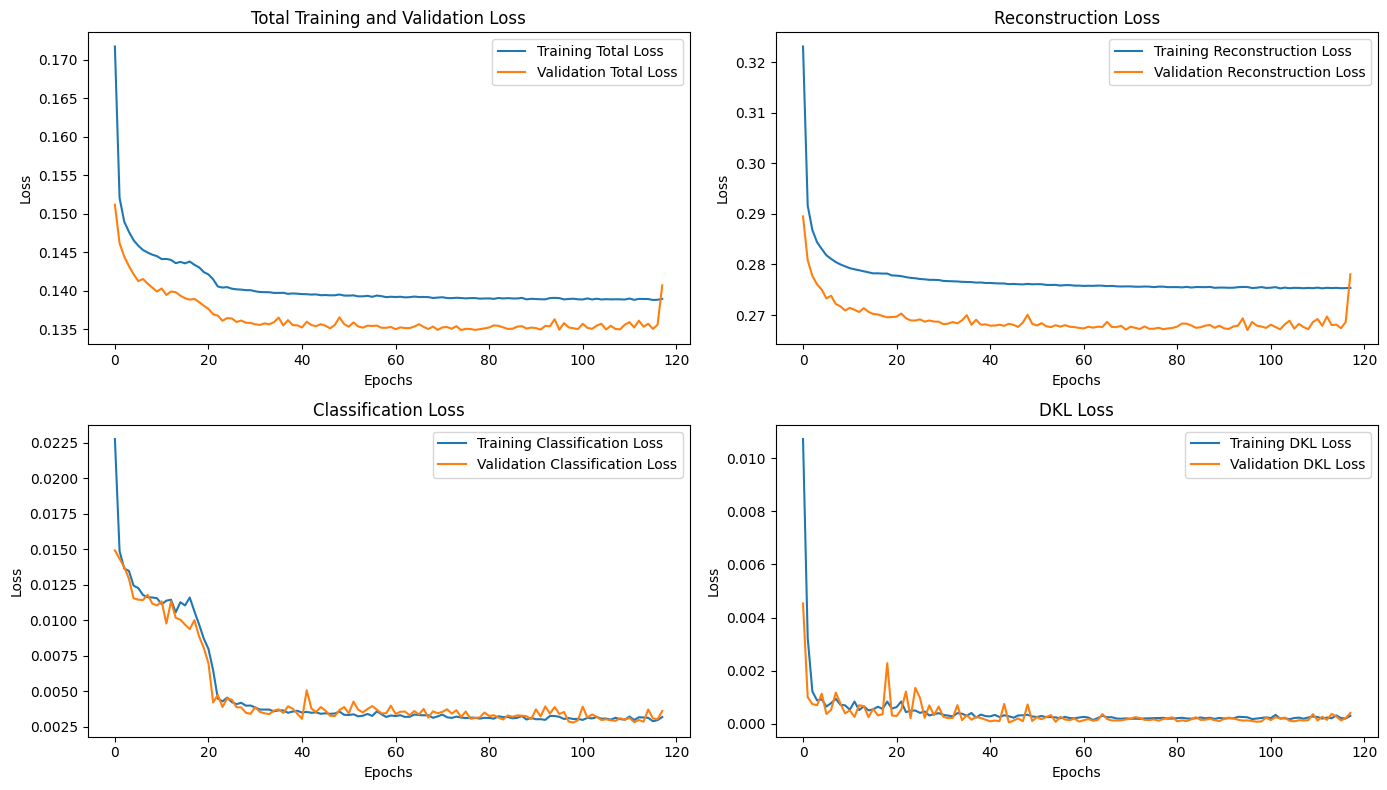

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']
reconstruction_loss = history.history['reconstruction_reconstruction_loss']
val_reconstruction_loss = history.history['val_reconstruction_reconstruction_loss']
classification_loss = history.history['softmax_output_mmd_loss']
val_classification_loss = history.history['val_softmax_output_mmd_loss']
dkl_loss = history.history['z_gaussian_dkl_loss']
val_dkl_loss = history.history['val_z_gaussian_dkl_loss']

plt.figure(figsize=(14, 8))

# Gráfico para la pérdida total
plt.subplot(2, 2, 1)
plt.plot(loss, label='Training Total Loss')
plt.plot(val_loss, label='Validation Total Loss')
plt.title('Total Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gráfico para la pérdida de reconstrucción
plt.subplot(2, 2, 2)
plt.plot(reconstruction_loss, label='Training Reconstruction Loss')
plt.plot(val_reconstruction_loss, label='Validation Reconstruction Loss')
plt.title('Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gráfico para la pérdida de clasificación
plt.subplot(2, 2, 3)
plt.plot(classification_loss, label='Training Classification Loss')
plt.plot(val_classification_loss, label='Validation Classification Loss')
plt.title('Classification Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gráfico para la pérdida DKL
plt.subplot(2, 2, 4)
plt.plot(dkl_loss, label='Training DKL Loss')
plt.plot(val_dkl_loss, label='Validation DKL Loss')
plt.title('DKL Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()
plt.show()

In [25]:
X_re = model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [26]:
len(X_re)

3

# *Clasification*

In [27]:
X_re[2].shape

(10000, 10)

In [28]:
# Obtén las predicciones de clasificación
softmax_output = X_re[2]  
predicted_labels = np.argmax(softmax_output, axis=1)

accuracy = accuracy_score(y_test, predicted_labels)
print("Accuracy:", accuracy)
print(classification_report(y_test, predicted_labels))

Accuracy: 0.8425
              precision    recall  f1-score   support

           0       0.76      0.84      0.80      1000
           1       0.98      0.96      0.97      1000
           2       0.70      0.80      0.74      1000
           3       0.84      0.86      0.85      1000
           4       0.78      0.63      0.70      1000
           5       0.97      0.94      0.95      1000
           6       0.60      0.55      0.57      1000
           7       0.91      0.96      0.93      1000
           8       0.94      0.95      0.95      1000
           9       0.96      0.94      0.95      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

